<a href="https://colab.research.google.com/github/yuezhuuuu/DeepLearning_Ebay/blob/master/ebay_background_remove_Model.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#Load Checkpoint from the check point files

In [0]:
!cp -R drive/My\ Drive/training_1/ ./training_1/
#move the folder

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/drive


In [8]:
!pip install git+https://github.com/tensorflow/examples.git

  Cloning https://github.com/tensorflow/examples.git to /tmp/pip-req-build-sjg7xl3e
  Running command git clone -q https://github.com/tensorflow/examples.git /tmp/pip-req-build-sjg7xl3e
  Created wheel for tensorflow-examples: filename=tensorflow_examples-7efe5195bc6318a669e4c1e85212d08eafe80923_-cp36-none-any.whl size=114174 sha256=d88a7bfdf114bf3dc8bd83b0ee1b5eaca8458355943b42f27950a27f70080af1
  Stored in directory: /tmp/pip-ephem-wheel-cache-srxh0_f3/wheels/83/64/b3/4cfa02dc6f9d16bf7257892c6a7ec602cd7e0ff6ec4d7d714d
Successfully built tensorflow-examples
  Found existing installation: tensorflow-examples 1844c5e53aa3b57d8daa2cde1b4d1517db954511-
    Uninstalling tensorflow-examples-1844c5e53aa3b57d8daa2cde1b4d1517db954511-:
      Successfully uninstalled tensorflow-examples-1844c5e53aa3b57d8daa2cde1b4d1517db954511-


In [0]:
import tensorflow as tf
#引入tensorflow
from tensorflow_examples.models.pix2pix import pix2pix
#pix2pix is a generator

from IPython.display import clear_output
import matplotlib.pyplot as plt
import numpy as np

In [0]:
#The model being used here is a modified U-Net. 
#A U-Net consists of an encoder (downsampler) and decoder (upsampler). In-order to learn robust features, 
#and reduce the number of trainable parameters, a pretrained model can be used as the encoder.
OUTPUT_CHANNELS = 3 
base_model = tf.keras.applications.MobileNetV2(input_shape=[128, 128, 3], include_top=False)
# the original model is UNet
# Use the activations of these layers
layer_names = [
    'block_1_expand_relu',   # 64x64
    'block_3_expand_relu',   # 32x32
    'block_6_expand_relu',   # 16x16
    'block_13_expand_relu',  # 8x8
    'block_16_project',      # 4x4
]
layers = [base_model.get_layer(name).output for name in layer_names]

# Create the feature extraction model
down_stack = tf.keras.Model(inputs=base_model.input, outputs=layers)

down_stack.trainable = False

up_stack = [
    pix2pix.upsample(512, 3),  # 4x4 -> 8x8
    pix2pix.upsample(256, 3),  # 8x8 -> 16x16
    pix2pix.upsample(128, 3),  # 16x16 -> 32x32
    pix2pix.upsample(64, 3),   # 32x32 -> 64x64
]

def unet_model(output_channels):
  inputs = tf.keras.layers.Input(shape=[128, 128, 3])
  x = inputs

  # Downsampling through the model
  skips = down_stack(x)
  x = skips[-1]
  skips = reversed(skips[:-1])

  # Upsampling and establishing the skip connections
  for up, skip in zip(up_stack, skips):
    x = up(x)
    concat = tf.keras.layers.Concatenate()
    x = concat([x, skip])

  # This is the last layer of the model
  last = tf.keras.layers.Conv2DTranspose(
      output_channels, 3, strides=2,
      padding='same')  #64x64 -> 128x128

  x = last(x)

  return tf.keras.Model(inputs=inputs, outputs=x)

In [0]:
def create_model():
    model = unet_model(OUTPUT_CHANNELS)
    model.compile(optimizer='adam',
                loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
                metrics=['accuracy'])
    return model

In [13]:
checkpoint_path = 'training_1/'
model = create_model()
latest = tf.train.latest_checkpoint(checkpoint_path)
model.load_weights(latest)

# Save it to saved model format

In [14]:
!mkdir -p saved_model
model.save('saved_model/unet') 

Instructions for updating:
If using Keras pass *_constraint arguments to layers.
INFO:tensorflow:Assets written to: saved_model/unet/assets


# Load model from saved model format

In [15]:
new_model = tf.keras.models.load_model('saved_model/unet')

# Check its architecture
new_model.summary()

Model: "model_3"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_4 (InputLayer)            [(None, 128, 128, 3) 0                                            
__________________________________________________________________________________________________
model_2 (Model)                 [(None, 64, 64, 96), 1841984     input_4[0][0]                    
__________________________________________________________________________________________________
sequential_8 (Sequential)       (None, 8, 8, 512)    1476608     model_2[1][4]                    
__________________________________________________________________________________________________
concatenate (Concatenate)       (None, 8, 8, 1088)   0           sequential_8[0][0]               
                                                                 model_2[1][3]              

In [0]:
def predict(input_image):
    #pre-processing
    ori_shape = input_image.shape[:2]
    ori_shape = ori_shape[::-1] #get original size

    input_image = cv2.resize(input_image, (128, 128)) #resize
    image = tf.image.convert_image_dtype(input_image, dtype=tf.float32, saturate=False)
    image = image[np.newaxis,:] #convert size to match th input size

    #do inference
    mask = new_model.predict(image)

    #generate mask
    mask = tf.argmax(mask, axis=-1)
    mask = mask[0,:]
    
    #post-processing
    clear_image = np.copy(input_image)
    clear_image[mask>0] = 255 #set background to white
    clear_image = cv2.resize(clear_image,ori_shape) #resize

    return clear_image

(1365, 2048, 3)


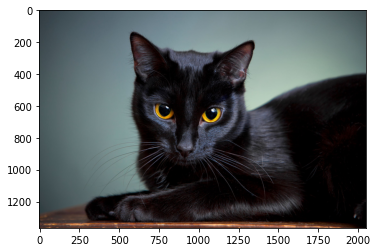

In [20]:
import cv2
im_cv = cv2.imread('cat.jpeg')
im_rgb = cv2.cvtColor(im_cv, cv2.COLOR_BGR2RGB)
input_image=im_rgb
plt.imshow(im_rgb)
print(im_rgb.shape)
#print(ori_shape)

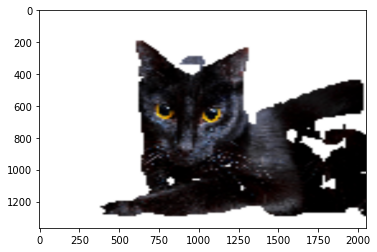

In [21]:
result = predict(input_image)
plt.imshow(result)

In [0]:
from io import BytesIO
from PIL import Image
img_bytes = open('cat.jpeg','rb').read()
img = np.array(Image.open(BytesIO(img_bytes)))

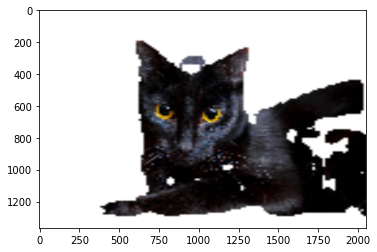

In [23]:
result = predict(img)
plt.imshow(result)

In [0]:
!cp -R saved_model/unet/ drive/My\ Drive/yuezhuzhang/